## Introduction

This notebook provides code for mixup contrastive learning. The method is illustrated on the gunpoint dataset. The dataset used in this notebook is the gunpoint dataset. But more are available. See https://github.com/alan-turing-institute/sktime/tree/master/sktime/datasets/data for more info.

The first two code block clones the sktime Github repo and loads the necessary packages.

In [1]:
#@title Clone Git repos

# !pip install sktime

In [2]:
#@title Load packages and data


import torch as th
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt


from IPython.display import clear_output
from sktime.datasets import load_gunpoint
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import json
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict as dd
from sklearn.cluster import KMeans
import copy

def to_np(x):
    return x.cpu().detach().numpy()

## Load data and create Pytorch dataset

The following two code block loads the data, converts it to numpy array, before wrapping it in the Pytorch dataset class.

In [3]:
# # replace ' with " in file
# with open("archive/endomondoHR.json", mode="r") as file:
#     with open("archive/endomondoHR_pre.json", mode="w") as output_file:
#         for index, line in enumerate(file):
#             training = json.loads(line.replace("'", '"'))
#             output_file.write(json.dumps(training).replace("\n", " ") + "\n")

In [4]:
N = 10000

In [5]:
classes_count = dd(int)

In [6]:
data_raw = []
speed_list = []
altitude_list = []
heart_rate_list = []
longitude_list = []
latitude_list = []
sport_list = []

In [7]:
with open("archive/endomondoHR_pre.json", mode="r") as file:
    for index, line in tqdm(enumerate(file)):
        if len(data_raw) >= N:
            break
        training = json.loads(line)
        if "speed" not in training.keys() or len(training["speed"]) != 500 \
            or len(training["altitude"]) != 500 or len(training["heart_rate"]) != 500 \
                  or len(training["longitude"]) != 500 or len(training["latitude"]) != 500 or classes_count[training["sport"]] > 1000:
            continue
        speed_list.append(training["speed"])
        altitude_list.append(training["altitude"])
        heart_rate_list.append(training["heart_rate"])
        longitude_list.append(training["longitude"])
        latitude_list.append(training["latitude"])
        sport_list.append(training["sport"])
        data_raw.append(training)
        classes_count[training["sport"]] += 1


253020it [01:25, 2943.42it/s]


In [8]:
pd.Series(np.array(sport_list)).value_counts()

bike                       1001
bike (transport)           1001
run                        1001
mountain bike              1001
indoor cycling              779
walk                        103
fitness walking              30
cross-country skiing         29
core stability training      23
roller skiing                19
skate                        12
orienteering                 11
kayaking                     10
hiking                        4
horseback riding              1
dtype: int64

In [9]:
# filter out classes with less than 100 samples

filter_data = [classes_count[x["sport"]] > 100 for x in data_raw]

speed_list = np.array(speed_list)[filter_data]
altitude_list = np.array(altitude_list)[filter_data]
heart_rate_list = np.array(heart_rate_list)[filter_data]
longitude_list = np.array(longitude_list)[filter_data]
latitude_list = np.array(latitude_list)[filter_data]
sport_list = np.array(sport_list)[filter_data]
data_raw = np.array(data_raw)[filter_data]

In [10]:
pd.Series(np.array(sport_list)).value_counts()

bike                1001
bike (transport)    1001
run                 1001
mountain bike       1001
indoor cycling       779
walk                 103
dtype: int64

In [11]:
print(pd.Series(sport_list).nunique())
index_2_sport = {index: sport for index, sport in enumerate(pd.Series(sport_list).unique())}
sport_2_index = {sport: index for index, sport in index_2_sport.items()}

6


In [12]:
X = np.stack([speed_list, altitude_list, heart_rate_list, longitude_list, latitude_list]).transpose(1, 0, 2).astype(np.float32)
y = np.expand_dims(np.array([sport_2_index[sport] for sport in sport_list]), axis=1).astype(np.int32)

In [13]:
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=2137)
x_tr.shape, y_tr.shape, x_te.shape, y_te.shape

((3908, 5, 500), (3908, 1), (978, 5, 500), (978, 1))

In [14]:
#@title load data and convert to numpy array

# x_tr, y_tr = load_gunpoint(split='train', return_X_y=True)

# x_tr = pd.DataFrame(x_tr).to_numpy()
# y_tr = pd.DataFrame(y_tr).to_numpy()

# x_tr = np.array(np.ndarray.tolist(x_tr), dtype=np.float32)
# y_tr = np.array(np.ndarray.tolist(y_tr), dtype=np.int32)

# x_te, y_te = load_gunpoint(split='test', return_X_y=True)


# x_te = pd.DataFrame(x_te).to_numpy()
# y_te = pd.DataFrame(y_te).to_numpy()

# x_te = np.array(np.ndarray.tolist(x_te), dtype=np.float32)
# y_te = np.array(np.ndarray.tolist(y_te), dtype=np.int32)

In [15]:
x_tr.shape,y_tr.shape

((3908, 5, 500), (3908, 1))

In [16]:
#@title create dataset

class MyDataset(Dataset):
    def __init__(self, x, y):

        device = 'cuda'
        self.x = th.tensor(x, dtype=th.float, device=device)
        self.y = th.tensor(y, dtype=th.long, device=device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Define neural network

In this block we define the neural network architecture used. This architecture is based on the fully convolutional network from https://arxiv.org/abs/1611.06455, but with dilation added to each convolutional layer.

In [17]:
#@title Define FCN

class FCN(nn.Module):
    def __init__(self, n_in):
        super(FCN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(n_in, 128, kernel_size=7, padding=6, dilation=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, padding=8, dilation=4),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=3, padding=8, dilation=8),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        self.proj_head = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):

        h = self.encoder(x)
        out = self.proj_head(h)

        return out, h

## Define loss, training function and evaluation function.

The following three code blocks implements the mixup contrastive loss, the training function and the evaluation function.

In [18]:
#@title define MixUp Loss

class MixUpLoss(th.nn.Module):

    def __init__(self, device, batch_size):
        super(MixUpLoss, self).__init__()
        
        self.tau = 0.5
        self.device = device
        self.batch_size = batch_size
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, z_aug, z_1, z_2, lam):

        z_1 = nn.functional.normalize(z_1)
        z_2 = nn.functional.normalize(z_2)
        z_aug = nn.functional.normalize(z_aug)

        labels_lam_0 = lam*th.eye(self.batch_size, device=self.device)
        labels_lam_1 = (1-lam)*th.eye(self.batch_size, device=self.device)

        labels = th.cat((labels_lam_0, labels_lam_1), 1)

        logits = th.cat((th.mm(z_aug, z_1.T),
                         th.mm(z_aug, z_2.T)), 1)

        loss = self.cross_entropy(logits / self.tau, labels)

        return loss

    def cross_entropy(self, logits, soft_targets):
        return th.mean(th.sum(- soft_targets * self.logsoftmax(logits), 1))


In [19]:
#@title mixup model trainer per epoch


def train_mixup_model_epoch(model, training_set, test_set, optimizer, alpha, epochs):

    device = 'cuda' if th.cuda.is_available() else 'cpu'
    batch_size_tr = len(training_set.x) // 30

    LossList, AccList 
    criterion = MixUpLoss(device, batch_size_tr)

    training_generator = DataLoader(training_set, batch_size=batch_size_tr,
                                    shuffle=True, drop_last=True)

    for epoch in tqdm(range(epochs)):

        for x, y in training_generator:

            model.train()

            optimizer.zero_grad()

            x_1 = x
            x_2 = x[th.randperm(len(x))]

            lam = np.random.beta(alpha, alpha)

            x_aug = lam * x_1 + (1-lam) * x_2

            z_1, _ = model(x_1)
            z_2, _ = model(x_2)
            z_aug, _ = model(x_aug)

            loss= criterion(z_aug, z_1, z_2, lam)
            loss.backward()
            optimizer.step()
            LossList.append(loss.item())


        AccList.append(test_model(model, training_set, test_set))

        if AccList[-1] == max(AccList):
            best_model = copy.deepcopy(model)

        print(f"Epoch number: {epoch}")
        print(f"Loss: {LossList[-1]}")
        print(f"Accuracy: {AccList[-1]}")
        print("-"*50)

        if epoch % 10 == 0 and epoch != 0: clear_output()
            
    return LossList, AccList, best_model

In [20]:
# #@title model evaluation


# def test_model(model, training_set, test_set):

#     model.eval()

#     N_tr = len(training_set.x)
#     N_te = len(test_set.x)

#     training_generator = DataLoader(training_set, batch_size=1,
#                                     shuffle=True, drop_last=False)
#     test_generator = DataLoader(test_set, batch_size= 1,
#                                     shuffle=True, drop_last=False)

#     H_tr = th.zeros((N_tr, 128))
#     y_tr = th.zeros((N_tr), dtype=th.long)

#     H_te = th.zeros((N_te, 128))
#     y_te = th.zeros((N_te), dtype=th.long)

#     for idx_tr, (x_tr, y_tr_i) in enumerate(training_generator):
#         with th.no_grad():
#             _, H_tr_i = model(x_tr)
#             H_tr[idx_tr] = H_tr_i
#             y_tr[idx_tr] = y_tr_i

#     H_tr = to_np(nn.functional.normalize(H_tr))
#     y_tr = to_np(y_tr)


#     for idx_te, (x_te, y_te_i) in enumerate(test_generator):
#         with th.no_grad():
#             _, H_te_i = model(x_te)
#             H_te[idx_te] = H_te_i
#             y_te[idx_te] = y_te_i

#     H_te = to_np(nn.functional.normalize(H_te))
#     y_te = to_np(y_te)

#     clf = KNeighborsClassifier(n_neighbors=1).fit(H_tr, y_tr)

#     return clf.score(H_te, y_te)


In [21]:
# caluclate accuracy based on kmeans clusters puirty

def test_model(model, training_set, test_set):
    model.eval()

    N_training = len(training_set.x)
    N_test = len(test_set.x)

    training_generator = DataLoader(training_set, batch_size=1,
                                    shuffle=True, drop_last=False)
    
    test_generator = DataLoader(test_set, batch_size=1,
                                    shuffle=True, drop_last=False)
    
    H_train = th.zeros((N_training, 128))
    y_train = th.zeros((N_training), dtype=th.long)

    H_test = th.zeros((N_test, 128))
    y_test = th.zeros((N_test), dtype=th.long)

    for idx_train, (x_train, y_train_i) in enumerate(training_generator):
        with th.no_grad():
            _, H_train_i = model(x_train)
            H_train[idx_train] = H_train_i
            y_train[idx_train] = y_train_i

    H_train = to_np(nn.functional.normalize(H_train))
    y_train = to_np(y_train)

    for idx_test, (x_test, y_test_i) in enumerate(test_generator):
        with th.no_grad():
            _, H_test_i = model(x_test)
            H_test[idx_test] = H_test_i
            y_test[idx_test] = y_test_i

    H_test = to_np(nn.functional.normalize(H_test))
    y_test = to_np(y_test)

    model = KMeans(n_clusters=10, random_state=2137, n_init=3).fit(H_train)
    cluster_labels = defaultdict(list)
    for i, label in enumerate(model.labels_):
        cluster_labels[label].append(y_train[i])
    cluster_labels = {k: max(set(v), key=v.count) for k, v in cluster_labels.items()}
    cluster_labels_test = model.predict(H_test)
    y_pred = np.array([cluster_labels[i] for i in cluster_labels_test])
    return np.sum(y_pred == y_test) / len(y_test)



## Block for training the model

This block trains the neural network using mixup contrastive learning. 

In [22]:
#@title Experiment number of epochs

device = 'cuda' if th.cuda.is_available() else 'cpu'
epochs, LossList, AccList = 20, [], []

alpha = 1.0

training_set = MyDataset(x_tr, y_tr)
test_set = MyDataset(x_te, y_te)

model = FCN(training_set.x.shape[1]).to(device)

optimizer = th.optim.Adam(model.parameters())
LossListM, AccListM, best_model = train_mixup_model_epoch(model, training_set, test_set,
                                              optimizer, alpha, epochs)






 60%|██████    | 12/20 [03:39<02:14, 16.76s/it]

Epoch number: 11
Loss: 3.9198849201202393
Accuracy: 0.614519427402863
--------------------------------------------------


 65%|██████▌   | 13/20 [03:55<01:56, 16.65s/it]

Epoch number: 12
Loss: 3.9340949058532715
Accuracy: 0.5858895705521472
--------------------------------------------------


 70%|███████   | 14/20 [04:11<01:38, 16.39s/it]

Epoch number: 13
Loss: 4.224521160125732
Accuracy: 0.6257668711656442
--------------------------------------------------


 75%|███████▌  | 15/20 [04:27<01:21, 16.26s/it]

Epoch number: 14
Loss: 4.295803546905518
Accuracy: 0.6390593047034765
--------------------------------------------------


 80%|████████  | 16/20 [04:43<01:04, 16.19s/it]

Epoch number: 15
Loss: 3.983461380004883
Accuracy: 0.5797546012269938
--------------------------------------------------


 85%|████████▌ | 17/20 [04:59<00:48, 16.10s/it]

Epoch number: 16
Loss: 4.627447128295898
Accuracy: 0.6104294478527608
--------------------------------------------------


 90%|█████████ | 18/20 [05:14<00:31, 15.99s/it]

Epoch number: 17
Loss: 3.8034937381744385
Accuracy: 0.5848670756646217
--------------------------------------------------


 95%|█████████▌| 19/20 [05:31<00:16, 16.04s/it]

Epoch number: 18
Loss: 4.440192699432373
Accuracy: 0.5858895705521472
--------------------------------------------------


100%|██████████| 20/20 [05:46<00:00, 17.35s/it]

Epoch number: 19
Loss: 4.564523220062256
Accuracy: 0.6094069529652352
--------------------------------------------------


Score for alpha = 1.0: 0.6094069529652352


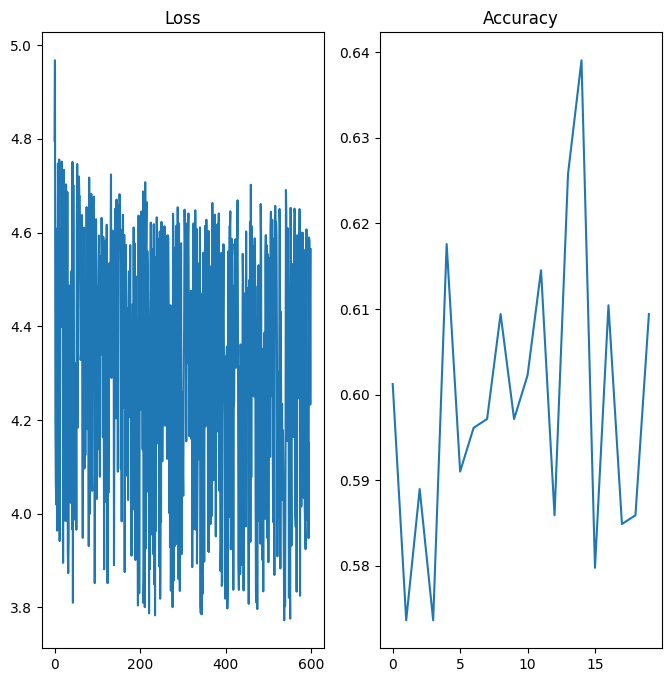

In [23]:
print(f"Score for alpha = {alpha}: {AccListM[-1]}")


plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(LossListM)
plt.title('Loss')
plt.subplot(122)
plt.plot(AccListM)
plt.title('Accuracy')
plt.show()

PCA

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Text(0.5, 0.98, 'Embeddings')

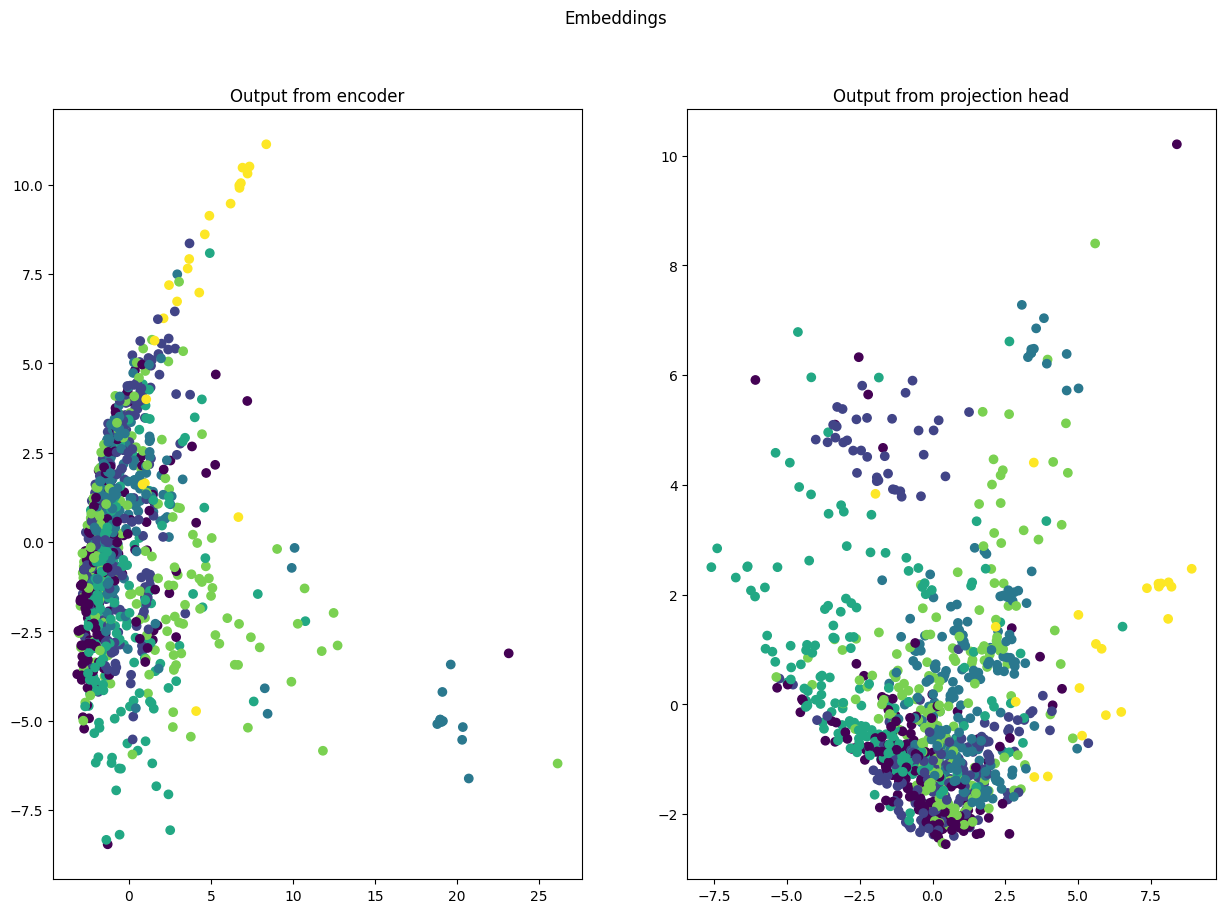

In [25]:
pca_model = PCA(n_components=2)
model.to("cpu")
with th.no_grad():
    embeddings = model.encoder(th.Tensor(x_te))
    embeddings_2 = model.proj_head(embeddings).numpy()
    embeddings_projected = pca_model.fit_transform(embeddings.numpy())
    embeddings_projected_2 = pca_model.fit_transform(embeddings_2)

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].scatter(embeddings_projected[:, 0], embeddings_projected[:, 1], c=y_te)
axs[0].set_title("Output from encoder")
axs[1].scatter(embeddings_projected_2[:, 0], embeddings_projected_2[:, 1], c=y_te)
axs[1].set_title("Output from projection head")

plt.suptitle("Embeddings")

Text(0.5, 0.98, 'Embeddings')

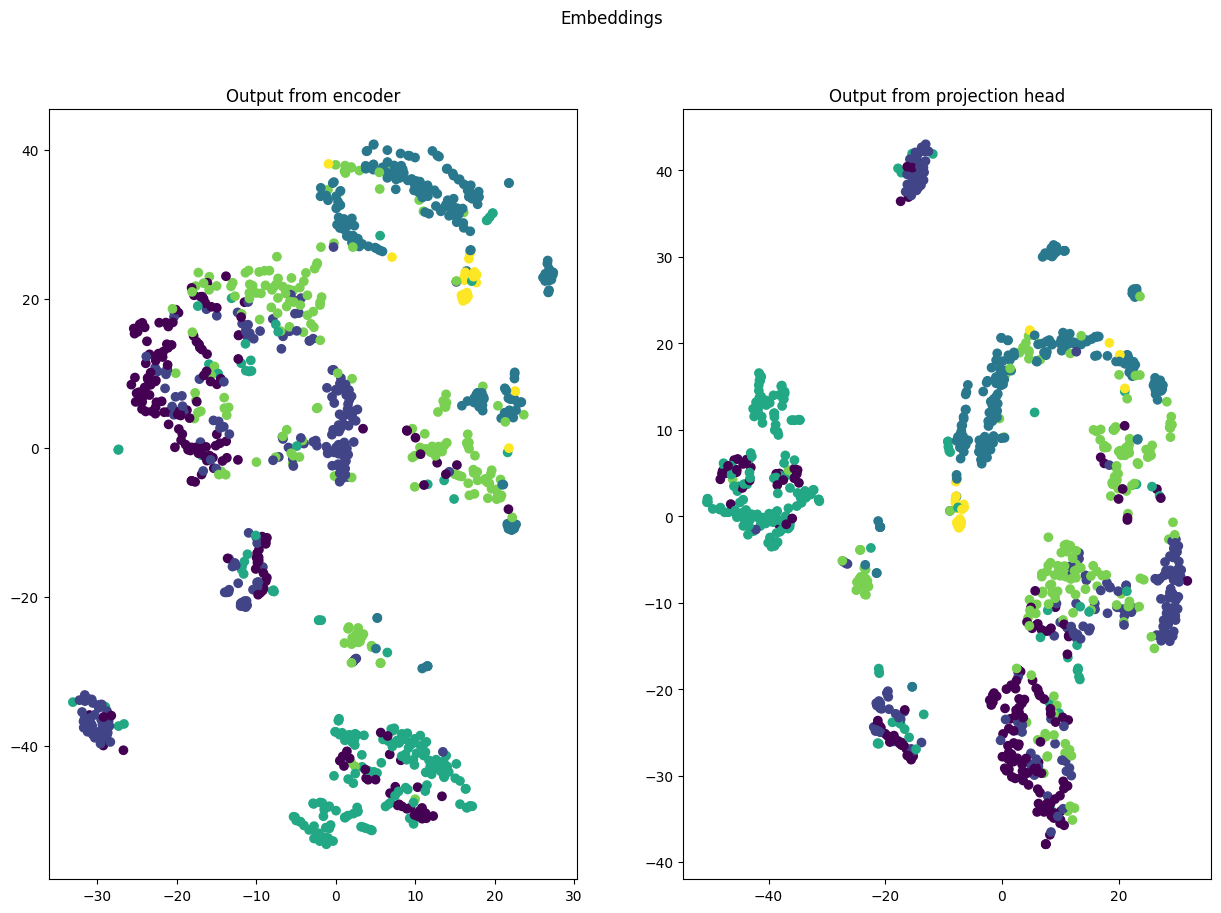

In [26]:
# t-SNE decomposition
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings.numpy())
embeddings_tsne_2 = tsne.fit_transform(embeddings_2)

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_te)
axs[0].set_title("Output from encoder")
axs[1].scatter(embeddings_tsne_2[:, 0], embeddings_tsne_2[:, 1], c=y_te)
axs[1].set_title("Output from projection head")

plt.suptitle("Embeddings")

PCA

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Text(0.5, 0.98, 'Embeddings')

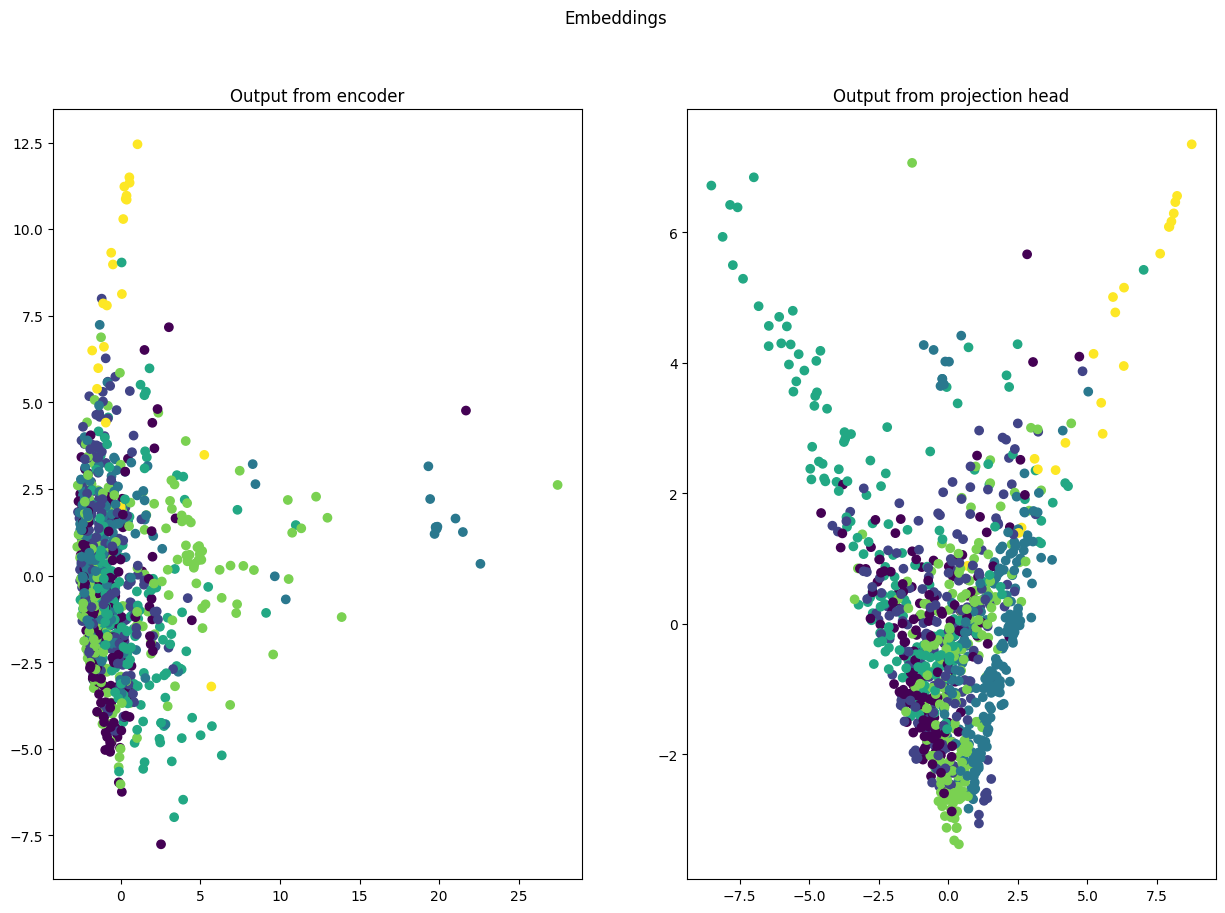

In [28]:
pca_model = PCA(n_components=2)
best_model.to("cpu")
with th.no_grad():
    embeddings = best_model.encoder(th.Tensor(x_te))
    embeddings_2 = best_model.proj_head(embeddings).numpy()
    embeddings_projected = pca_model.fit_transform(embeddings.numpy())
    embeddings_projected_2 = pca_model.fit_transform(embeddings_2)

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].scatter(embeddings_projected[:, 0], embeddings_projected[:, 1], c=y_te)
axs[0].set_title("Output from encoder")
axs[1].scatter(embeddings_projected_2[:, 0], embeddings_projected_2[:, 1], c=y_te)
axs[1].set_title("Output from projection head")

plt.suptitle("Embeddings")

Text(0.5, 0.98, 'Embeddings')

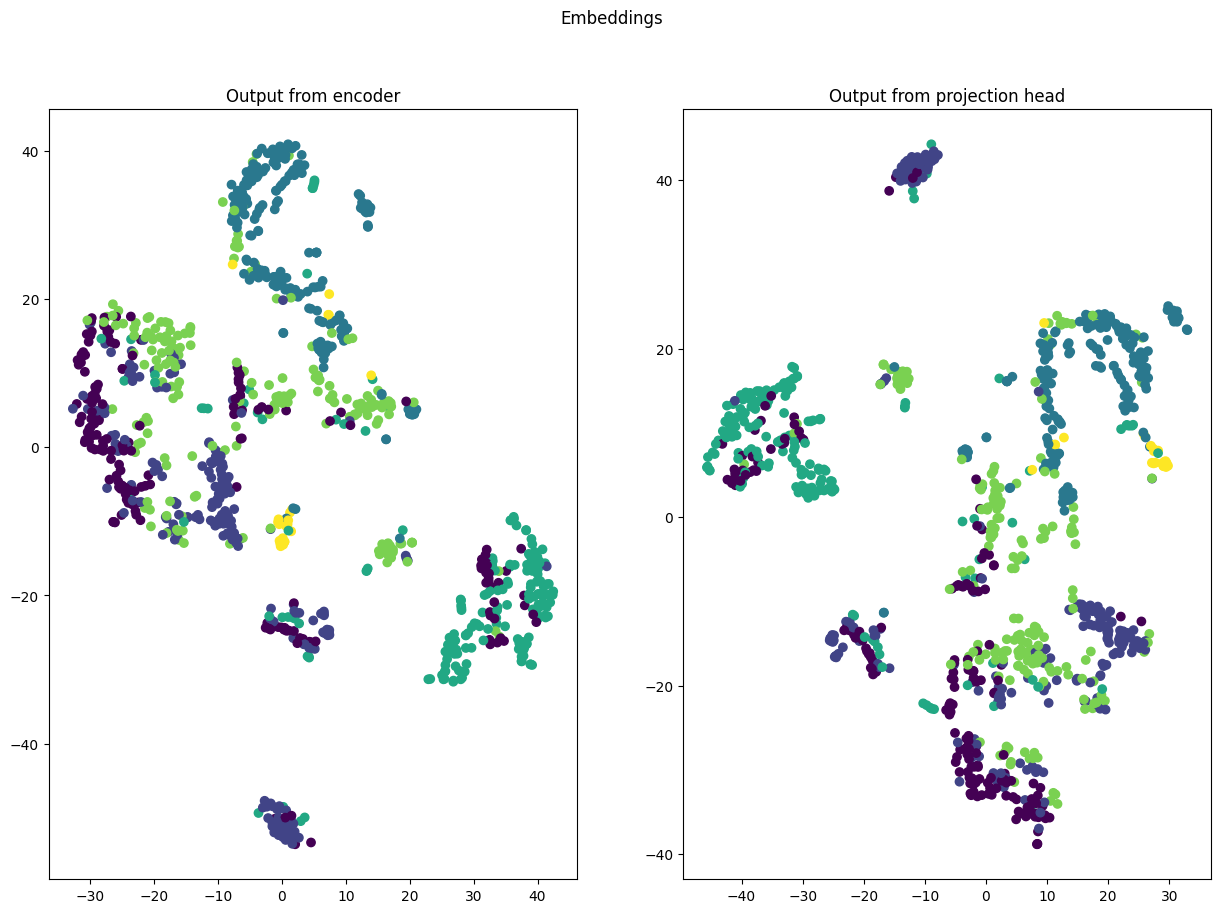

In [29]:
# t-SNE decomposition
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings.numpy())
embeddings_tsne_2 = tsne.fit_transform(embeddings_2)

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_te)
axs[0].set_title("Output from encoder")
axs[1].scatter(embeddings_tsne_2[:, 0], embeddings_tsne_2[:, 1], c=y_te)
axs[1].set_title("Output from projection head")

plt.suptitle("Embeddings")